# Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import session_info
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

In [3]:
try:
    session_info_output = session_info.show()
except Exception as error:
    print("The session info has been requested already:")
    
session_info_output

In [4]:
import janitor # This library generates an error when I execute session_info()

# Import external files

- Extension of the "missing" functions from Pandas
- DataFrame and dictionary functions
- Statistical functions

In [5]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb
%run utils/u.0.2-statistical-functions.ipynb

/home/ubuntu/anaconda3/lib/python3.11/site-packages/upsetplot/plotting.py:15: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


# Get the processed data (v2)

In [13]:
arg_di_df = pd.read_csv('../data/processed/WDICSV_PROCESSED_V2.csv').clean_names(case_type="snake")

print(arg_di_df.shape)
arg_di_df.info()

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/WDICSV_PROCESSED_V2.csv'

# Get columns names and types

In [7]:
indicators_names, categorical_cols, numeric_cols, columns_with_missing_values = get_columns(arg_di_df)

In [12]:
print(f'Total Columns: {len(indicators_names)}')
print(f'Categorical Columns: {len(categorical_cols)}')
print(f'Numeric Columns: {len(numeric_cols)}')

Total Columns: 28
Categorical Columns: 6
Numeric Columns: 22


In [8]:
indicators_names

['year, Year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 'sm_pop_refg_or, Refugee population by country or territory of origin',
 'se_pre_enrr, School enrollment, preprimary (% gross)',
 'se_prm_enrr, School enrollment, primary (% gross)',
 'se_sec_enrr, School enrollment, secondary (% gross)',
 'se_ter_enrr, School enrollment, tertiary (% gross)',
 'sp_urb_totl_in_zs,

In [9]:
columns_with_missing_values

['se_ter_enrr',
 'sm_pop_refg_or',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'it_cel_sets',
 'it_cel_sets_pct',
 'sp_dyn_le00_in',
 'sh_dth_imrt']

# Target variable:

sp_dyn_le00_in (Life expectancy at birth, total (years))

In [106]:
target_variable = "sp_dyn_le00_in"
target_variable_name = get_indicator_name(target_variable, True)

# Apply statistical functions

## TTest

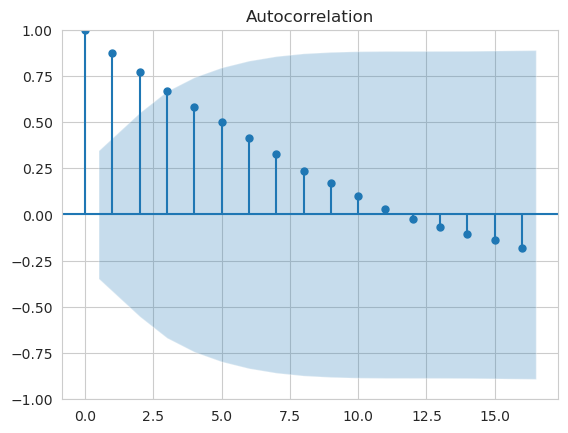

Normality of sample 0? False
Normality of sample 1? False
Equality of variances? True


TtestResult(statistic=-6.492353268172686, pvalue=7.771964816118865e-08, df=42.0)

In [114]:
def get_groups_of_missing_values(data, grouping_variable, grouped_variable):

    indexes_of_grouping_variable = arg_di_df.value_counts(grouping_variable, dropna=False).index
    
    grouped_variable = columns_with_missing_values[0]
    grouped_variable_description = get_indicator_name(grouped_variable, True)

    groupby_series = (
        data
            .rename(columns={grouped_variable: grouped_variable_description})
            .loc[:,[grouping_variable, grouped_variable_description]]
            .dropna()
            .groupby(grouping_variable)
    )

    group_1 = pd.DataFrame() if groupby_series.indices.get(indexes_of_grouping_variable[1]) is None else groupby_series.get_group(indexes_of_grouping_variable[1]).loc[:,grouped_variable_description]
    group_2 = pd.DataFrame() if groupby_series.indices.get(indexes_of_grouping_variable[0]) is None else groupby_series.get_group(indexes_of_grouping_variable[0]).loc[:,grouped_variable_description]

    return group_1, group_2

group_1, group_2 = get_groups_of_missing_values(arg_di_df, "year_of_dictatorship", columns_with_missing_values[1])

ttest_ind_and_conditions(group_1,group_2)

What does this plot tell us about the data?

* There is significant autocorrelation at lower lags (strong dependency on past values).
* The autocorrelation decreases over time, eventually turning negative.
* This pattern suggests the data is not purely random and could be modeled using time series techniques, such as an ARMA or ARIMA model (AutoRegressive Moving Average and AutoRegressive Integrated Moving Average respectively)

# Transform categorical variables

## Ordinal coding

This method implies to transform every category into an integer. It's useful when the categories have an order.

### Apply to a group of columns

Column transformer: Applies transformers to columns of an array or pandas DataFrame.

make_column_transformer(): Construct a ColumnTransformer from the given transformers. This is a shorthand for the ColumnTransformer constructor; it does not require, and does not permit, naming the transformers. Instead, they will be given names automatically based on their types.


In [117]:
categorical_variables_ordered_values = [list(item.keys()) for item in df_categorical_values["Indicator Colors"]]

for item in categorical_variables_ordered_values:
    item.remove("Unknown")
    item.insert(0, "Unknown")

In [118]:
ordinal_encoder = OrdinalEncoder(categories= categorical_variables_ordered_values)

In [119]:
categorical_transformer = sklearn.compose.make_column_transformer(
    # Tuples of the form (transformer, columns) specifying the transformer objects to be applied to subsets of the data
    (ordinal_encoder, df_categorical_values["Indicator Name"]),
    remainder="passthrough"
    # By specifying remainder='passthrough', all remaining columns that were not specified in transformers,
    # but present in the data passed to fit will be automatically passed through. This subset of columns is
    # concatenated with the output of the transformers. For dataframes, extra columns not seen during fit
    # will be excluded from the output of transform. 
)

In [120]:
arg_di_df_transformed = (
    pd.DataFrame(
        categorical_transformer.fit_transform(arg_di_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=arg_di_df.index
    )
    .rename(
        columns=remove_prefix
    )
)

In [121]:
categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(categories=[['Unknown',
                                                             'Negative growth',
                                                             'Low growth',
                                                             'Moderate growth',
                                                             'High growth'],
                                                            ['Unknown',
                                                             'Low life '
                                                             'expectancy',
                                                             'Medium life '
                                                             'expectancy',
                                                             'High life '
                                                             'expectancy'],
                                                            ['Unknown', 'Low',
                                                             'Medium', 'High',
                                                             'Very High'],
                                                            ['Unknown',
                                                             'Low income',
                                                             'Middle income',
                                                             'High income'],
                                                            ['Unknown', 'Low',
                                                             'Medium', 'High'],
                                                            ['Unknown',
                                                             'Low volatility',
                                                             'Medium '
                                                             'volatility',
                                                             'High '
                                                             'volatility']]),
                                 0     ny_gdp_mktp_kd_zg_cat
1        sp_dyn_le00_in_cat
2           it_cel_sets_cat
3        ny_gdp_pcap_kd_cat
4           se_sec_enrr_cat
5    ny_gdp_mktp_kd_grw_cat
Name: Indicator Name, dtype: object)])

In [122]:
ordinal = categorical_transformer.named_transformers_['ordinalencoder']
# Check categories for each column
for col_name, categories in zip(list(df_categorical_values["Indicator Name"]), ordinal.categories_):
    print(f"{col_name}:")
    for i, cat in enumerate(categories):
        print(f"  {cat} → {i}")

ny_gdp_mktp_kd_zg_cat:
  Unknown → 0
  Negative growth → 1
  Low growth → 2
  Moderate growth → 3
  High growth → 4
sp_dyn_le00_in_cat:
  Unknown → 0
  Low life expectancy → 1
  Medium life expectancy → 2
  High life expectancy → 3
it_cel_sets_cat:
  Unknown → 0
  Low → 1
  Medium → 2
  High → 3
  Very High → 4
ny_gdp_pcap_kd_cat:
  Unknown → 0
  Low income → 1
  Middle income → 2
  High income → 3
se_sec_enrr_cat:
  Unknown → 0
  Low → 1
  Medium → 2
  High → 3
ny_gdp_mktp_kd_grw_cat:
  Unknown → 0
  Low volatility → 1
  Medium volatility → 2
  High volatility → 3


In [123]:
arg_di_df_transformed[categorical_cols].head(5)

,ny_gdp_mktp_kd_zg_cat,sp_dyn_le00_in_cat,it_cel_sets_cat,ny_gdp_pcap_kd_cat,se_sec_enrr_cat,ny_gdp_mktp_kd_grw_cat
0,3.0,2.0,1.0,2.0,2.0,0.0
1,4.0,2.0,0.0,2.0,2.0,0.0
2,2.0,2.0,0.0,2.0,2.0,2.0
3,3.0,2.0,0.0,2.0,2.0,1.0
4,4.0,2.0,0.0,2.0,2.0,1.0


## Scale Numerical Features

In [126]:
scaler = MinMaxScaler()